<a href="https://colab.research.google.com/github/Ayan-Vishwakarma/Keras-Implementation-of-Dense-and-DC-NSGAN-WGAN-WGANGP-etc/blob/main/ProGAN_code_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt

import glob
from keras.layers import *

## Pixelwise Vector Normalization:

According to  https://arxiv.org/abs/1710.10196, due to unhealthy comptetion between the generator and discriminator the gradient magnitude may become very high. 

BatchNormalization helps this by controlling the gradient magnitude, as it involves first making the mean zero and variance 1 of the input features, and then tranforming the mean to some value alpha and variance to value beta, where alpha and beta are learnable parameters.

This method helps the gradient magnitude to not blow up, but since we do not need to take care of covariance-shift in batch, the BatchNormalization trick proves very expensive both in memory and computation terms,since the estimated mean and variance is for only the feature space (last channel axis) , taking average along the batch_size , height and width.This takes a lot of unnecessary computational time for GANs.

For this reason, Pixelwise vector Normalization was used in which the feature vector at each pixel is normalized to have unit norm.For me, this had much better results than BatchNormalization, in terms of image quality and training speed.Also, since it does not use Batch mean and variance, implies that the disharmony seen between BatchNormalization and Dropout is not seen in case of PixVecNormalization giving the ability to use Dropout between the layers.

In [ ]:
class PixVecNormalization(keras.layers.Layer):
  def __init__(self,axis=-1,**kwargs):
    super().__init__(**kwargs)
    self.axis = axis
  def call(self,inputs):
    return tf.math.l2_normalize(inputs,self.axis)
  def compute_output_shape(self,input_shape):
    return input_shape
  def get_config(self):
    return {"name":self.name,"axes":self.axis}

## Progressive Growing of GANs

According to the [Progressive Growing of GANs](https://arxiv.org/abs/1710.10196), the major reason of training difficulty of GANs is due to lack of overlap between the true distribution and generated distribution, in which cases gradients point at arbitrary directions. The chance of low overlap increases in higher dimensions, because of which it becomes very hard to train GANs for high resolution images. 

This paper provides a different training approach in which, the image is resized to smaller resolution providing a smaller compact space for training in which the overlap between the resized image distribution and initial generator's distribution is good enough. When the networks are trained,just upscaling the generated image gives better initial overlap between the higher resolution space w.r.t. the real distribution.

Both the networks are trained and then new layers are added so that the networks now work in higher resolution. This process is repeated until desired resolution is reached. In the paper, simply appending/prepending new layers in the networks is avoided as it provides sudden shock to the networks and uncontrolled gradients.Instead of it, a differnt approch is used which weighted addition of output of upscaled previous output and newly added layers' output.

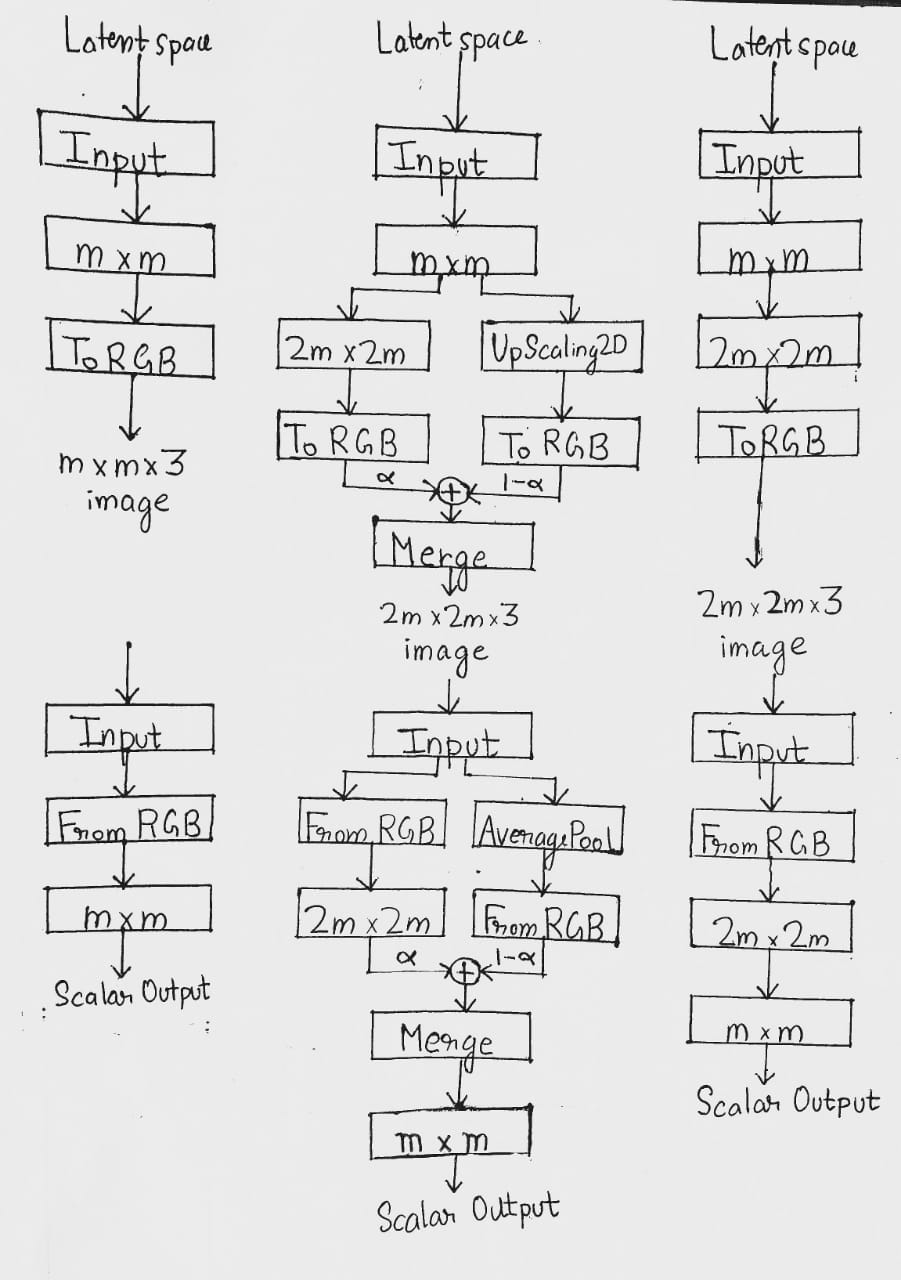

**mxm Model** -------------------------------------------------------> **Progress GAN** ---------------------------------------> **Streamline GAN 2mx2m**

Here a ( 2m x 2m )-Functional-generator block accepts a ( m x m ) image and outputs a ( 2m x 2m ) image output.The number of feature maps can be arbitrary. 

A ( 2m x 2m )-Functional-discriminator block accepts extracted extract_dims features from image of shape ( m x m ) and outputs ( 2m x 2m ) image. The output feature maps of ( 2m x 2m )-discriminator block should match to that of ( m x m ) input feature maps represented by model's extract_dims atribute.

The multiplier in this case is (2,2).However any multiplier can be used but power of 2 are preferred due to better memory utilization.

PGGAN( initial_generator_block , initial_discriminator_block , z_dim , image_shape , extract_dims , trainer = "NSGAN" )

> initial_generator_block : Initial generator block [Model] which takes in z_dim vector and returns image_shape's height * image_shape's width * out_channels.
>> The images output passes though tanh activation and so are between -1 to 1 value.So the training images should be initially rescaled between -1 to 1.

> initial_generator_block : Initial generator block[Model] which takes in z_dim vector and returns image_shape dimensional image. The input will be image_shape's height * image_shape's width * extract_dims and output will be a scalar.
>> For NSGAN trainer, output should have **sigmoid** activation.

>> For WGAN_GP trainer, output should **not** have any activation.

> z_dim : Latent space dimension.

> image_shape : Initial resolution of images.

> extract_dims : Number of feature maps the FROM RGB block extracts.

>trainer : Training model.Either NSGAN or WGAN_GP.

ProgressGAN(add_functional_generator , add_functional_discriminator , multiplier , n_intervals , extract_dims=None):

>add_functional_generator : Keras Model [ Functional or Sequential ] to be added to previously trained generator.

>add_functional_discriminator : Keras Model [ Functional or Sequential ] to be added to previously trained discriminator.

> multiplier : Tuple (mh,mw) , where (mh,mw) represents the ratio between new image resolution to the older image resolution. The add_functional_generator and add_functional_discriminator should accomodate these changes. 

> n_intervals: The alpha value used in the MergeLayer uniformly increases in value and takes a total of n_intervals to reach from 0 to 1. The alpha is same as that mentioned in the  paper, which is used for slowly accomodating changes.

> extract_dims : The number of feature maps the From RGB extracts for the add_functional_discriminator model. If not given, then From RGB for newly added layers has same structure as the From RGB used by older layers.

StreamlineGAN()

> It removes the auxillary layers and the Merge layer as shown in the above figure.

Attributes:

>generator

>discriminator

>extract_dims

>z_dim

>image_shape


Based on which trainer used:

>NSGAN

>WGAN_GP



In [ ]:
#Merges 2 input tensors by giving 0 weight to first input and then slowly increasing the weight till 1 and finally reducing the weight of input 2 to 0
class MergeLayer(keras.layers.Layer):
  def __init__(self,n_intervals,**kwargs):
    super().__init__(**kwargs)
    self.alpha = tf.Variable([0.],trainable=False)
    self.n_intervals = tf.Variable([n_intervals],dtype=tf.float32,trainable=False)
  def call(self,inputs):
    self.alpha.assign(tf.clip_by_value(self.alpha + tf.math.reciprocal(self.n_intervals),clip_value_min=0.,clip_value_max = 1.))
    return self.alpha * inputs[0] + (1 - self.alpha) * inputs[1]
  def compute_output_shape(self,input_shape):
    return input_shape
  def get_config(self):
    return {"name":self.name,"alpha":self.alpha,"n_intervals":self.n_intervals}

In [ ]:
class PGGAN():
  def __init__(self,initial_generator_block,initial_discriminator_block,z_dim,image_shape,extract_dims,trainer = "NSGAN",**kwargs):
    super().__init__(**kwargs)
    self.z_dim = z_dim
    self.extract_dims = extract_dims
    self.image_shape = image_shape

    ######################################  Initial Generator  ###########################################################################
    xin = keras.layers.Input((z_dim))
    x = initial_generator_block(xin)
    x = keras.layers.Conv2D(3,(1,1),(1,1),padding="same",activation="tanh")(x)
    self.generator = keras.models.Model(inputs=[xin],outputs=[x])

    ######################################  Initial Discriminator  #######################################################################
    xin = keras.layers.Input(image_shape)
    x = keras.layers.Conv2D(extract_dims,(1,1),(1,1),padding="same")(xin)
    x = keras.layers.LeakyReLU(0.05)(x)
    x = initial_discriminator_block(x)
    self.discriminator = keras.models.Model(inputs=[xin],outputs=[x])

    ######################################  Trainer  ####################################################################################
    self.trainer = trainer.upper()
    assert self.trainer == "NSGAN" or self.trainer == "WGAN_GP","trainer should be NSGAN or WGAN_GP"
    if self.trainer == "NSGAN":
      self.NSGAN = NSGAN(self.generator,self.discriminator,self.z_dim)
    elif self.trainer == "WGAN_GP":
      self.WGAN_GP = WGAN_GP(self.generator,self.discriminator,self.z_dim)
  
  def ProgressGAN(self,add_functional_generator,add_functional_discriminator,multiplier,n_intervals,extract_dims=None):
    ##########################################  Progress Discriminator  ################################################################
    image_shape = self.image_shape
    discriminator = self.discriminator
    try :
      self.rdl = []
      if extract_dims != None :
        self.extract_dims = extract_dims

      self.image_shape = self.image_shape * np.concatenate([np.array(multiplier,dtype=np.int32),np.array([1],dtype=np.int32)],axis=0)
      xin = keras.layers.Input(self.image_shape)
      y = xin

      layer = keras.layers.AveragePooling2D(multiplier)
      self.rdl.append(layer.name)
      x = layer(xin)
      for i in self.discriminator.layers[1:3]:
        self.rdl.append(i.name)
        x = i(x)
      y = keras.layers.Conv2D(self.extract_dims,(1,1),(1,1),padding='same')(y)
      y = keras.layers.LeakyReLU(0.05)(y)
      y = add_functional_discriminator(y)
      
      layer = MergeLayer(n_intervals)
      self.rdl.append(layer.name)
      x = layer([y,x])
      
      for i in self.discriminator.layers[3:]:
        x = i(x)

      self.discriminator = keras.models.Model(inputs=[xin],outputs = [x])
    except Exception as e:
      self.discriminator = discriminator
      self.image_shape = image_shape
      print(e)
      return 

    #########################################  Progress Generator  ######################################################################

    xin = keras.layers.Input((self.z_dim))
    x = xin

    self.rgl = []

    for i in self.generator.layers[1:-1]:
      x = i(x)
    y = x
    
    x = add_functional_generator(x)
    x = keras.layers.Conv2D(3,(1,1),(1,1),padding="same",activation="tanh")(x)

    layer = keras.layers.UpSampling2D(multiplier)
    y = layer(y)
    self.rgl.append(layer.name)
    layer = self.generator.layers[-1]
    self.rgl.append(layer.name)
    y = layer(y)

    layer = MergeLayer(n_intervals)
    self.rgl.append(layer.name)
    z = layer([x,y])

    self.generator = keras.models.Model(inputs=[xin],outputs=[z])

    ######################################  Trainer  #####################################################################################
    if self.trainer == "NSGAN":
      self.NSGAN = NSGAN(self.generator,self.discriminator,self.z_dim)
    elif self.trainer == "WGAN_GP":
      self.WGAN_GP = WGAN_GP(self.generator,self.discriminator,self.z_dim)

  def StreamlineGAN(self):

    ###################################################  Streamline Generator  ########################################################
    xin = keras.layers.Input((self.z_dim))
    x = xin
    for i in self.generator.layers[1:]:
      if i.name not in self.rgl:
        x = i(x)
    
    self.generator = keras.models.Model(inputs=[xin],outputs=[x])

    ##################################################  Streamline  Discriminator  ###################################################
    xin = keras.layers.Input(self.image_shape)
    x = xin
    for i in self.discriminator.layers[1:]:
      if i.name not in self.rdl:
        x = i(x)
    
    self.discriminator = keras.models.Model(inputs=[xin],outputs=[x])

    ######################################  Trainer  #####################################################################################
    if self.trainer == "NSGAN":
      self.NSGAN = NSGAN(self.generator,self.discriminator,self.z_dim)
    elif self.trainer == "WGAN_GP":
      self.WGAN_GP = WGAN_GP(self.generator,self.discriminator,self.z_dim)

## Learning Rate Equalization

In this method, rather than using Xavier/He's initialization, standard Normal distribution is used for initializing weights.Then during the runtime, the weights are dynamically scaled by the Xavier/He's factor.

This serves the same purpose as that of Pixelwise Normalization by providing scaled learning rates based on input of the layers.

**Modified Conv2D, Conv2DTranspose and Dense layer to take the account for Equalized learning rate.**

>ConvEq2D( filters , kisize , strides , padding , activation=None )

>ConvEq2DTranspose( filters , ksize , strides , padding , activation=None )

>DenseEq( units , activation )

In [ ]:
class ConvEq2D(keras.layers.Layer):

  def __init__(self,filters,ksize,strides,padding,activation=None,input_shape=None,**kwargs):
    super().__init__(**kwargs)
    self.filters = tf.constant(filters,dtype=tf.int32)
    self.f = filters
    self.ksize = tf.constant(ksize,dtype = tf.int32)
    self.ks = ksize
    self.strides = strides
    if isinstance(strides,int):
      self.strides = (strides,strides)
    assert isinstance(strides[0],int),"stride value must be int"
    self.padding = padding.upper()
    assert self.padding == "SAME" or self.padding == "VALID","padding should be either same or valid"
    
    if activation == None:
      self.activation = None
    elif activation.lower() == "sigmoid":
      self.activation = tf.sigmoid
    elif activation.lower() == "relu":
      self.activation = tf.nn.relu
    else:
      assert False,"Unknown Activation"
    if input_shape!=None:
      self.build((-1,*input_shape))

  def build(self,input_shape):
    self.kernel = tf.Variable(tf.random.normal(tf.concat([self.ksize,tf.constant(input_shape[3],shape=(1,)),tf.constant(self.filters,shape=(1,))],axis=0)),trainable=True)
    self.bias = tf.Variable(tf.random.normal(tf.constant(self.filters,shape=(1,))),trainable=True)
    self.c = tf.Variable(tf.math.sqrt(2./(tf.math.reduce_prod(tf.cast(self.ksize,dtype=tf.float32))*tf.cast(input_shape[3],tf.float32))),trainable = False)
  
  def call(self,inputs):
    out = tf.nn.conv2d(inputs,self.kernel*self.c,strides = self.strides,padding = self.padding)
    out = tf.add(out,self.bias)
    if self.activation != None:
      out = self.activation(out)
    return out

  def compute_output_shape(self,input_shape):
    H,W,_ = input_shape
    kh,kw = self.ksize
    if self.padding == "SAME":
      ph,pw = (kh//2,kw//2)
    else :
      ph,pw = (0,0)
    sh,sw = self.strides
    
    return tf.constant([(H + 2*ph - kh)//sh,(W + 2*pw - kw)//sw,self.f])

In [ ]:
class ConvEq2DTranspose(keras.layers.Layer):

  def __init__(self,filters,ksize,strides,padding,activation=None,input_shape=None,**kwargs):
    super().__init__(**kwargs)
    self.filters = tf.constant(filters,dtype=tf.int32)
    self.ksize = tf.constant(ksize,dtype = tf.int32)
    self.f = filters
    self.strides = strides
    if isinstance(strides,int):
      self.strides = (strides,strides)
    assert isinstance(strides[0],int),"stride value must be int"
    self.padding = padding.upper()
    assert self.padding == "SAME" or self.padding == "VALID","padding should be either same or valid"
    
    if activation == None:
      self.activation = None
    elif activation.lower() == "sigmoid":
      self.activation = tf.sigmoid
    elif activation.lower() == "relu":
      self.activation = tf.nn.relu
    else:
      assert False,"Unknown Activation"
    if input_shape!=None:
      self.build((-1,*input_shape))

  def build(self,input_shape):
    self.kernel = tf.Variable(tf.random.normal(tf.concat([self.ksize,tf.constant(self.filters,shape=(1,)),tf.constant(input_shape[3],shape=(1,))],axis=0)),trainable=True)
    self.bias = tf.Variable(tf.random.normal(tf.constant(self.filters,shape=(1,))),trainable=True)
    self.c = tf.Variable(tf.math.sqrt(2./(tf.math.reduce_prod(tf.cast(self.ksize,dtype=tf.float32))*tf.cast(input_shape[3],tf.float32))),trainable = False)
    if self.padding == "SAME":
      self.outputshape = tf.concat([(tf.constant(input_shape[1],shape=(1,)))*self.strides[0],(tf.constant(input_shape[2],shape=(1,)))*self.strides[1]],axis=0)
    else :
      self.outputshape = tf.concat([(tf.constant(input_shape[1],shape=(1,))-1)*self.strides[0] + self.ksize[0] ,(tf.constant(input_shape[2],shape=(1,))-1)*self.strides[1] + self.ksize[1]],axis=0)
      
  def call(self,inputs):
    out = tf.nn.conv2d_transpose(inputs,self.kernel*self.c,self.outputshape,strides = self.strides,padding = self.padding)
    out = tf.add(out,self.bias)
    if self.activation != None:
      out = self.activation(out)
    return out

  def compute_output_shape(self,input_shape):
    H,W,_ = input_shape
    kh,kw = self.ksize
    sh = sw = self.strides
    if self.padding=="SAME":
      return tf.constant([(H*sh ),(W *sw),self.f])
    else :
      return tf.constant([((H-1)*sh + kh),((W-1)*sw + kw),self.f])

In [ ]:
class DenseEq(keras.layers.Layer):

  def __init__(self,units,activation=None,input_dim = None,**kwargs):
    super().__init__(**kwargs)
    self.units = tf.constant(units,dtype = tf.int32)
    self.u = units

    if activation == None:
      self.activation = None
    elif activation.lower() == "sigmoid":
      self.activation = tf.sigmoid
    elif activation.lower() == "relu":
      self.activation = tf.nn.relu
    else:
      assert False,"Unknown Activation"
    if input_dim != None:
      self.build((-1,input_dim))

  def build(self,input_shape):
    self.kernel = tf.Variable(tf.random.normal(tf.concat([tf.constant(input_shape[1],shape=(1,)),tf.constant(self.units,shape=(1,))],axis=0)),trainable=True)
    self.bias = tf.Variable(tf.random.normal((self.units,)),trainable=True)
    self.c = tf.Variable(tf.math.sqrt(2./tf.cast(input_shape[1],dtype = tf.float32)),trainable = False)
  
  def call(self,inputs):
    out = tf.matmul(inputs,self.kernel*self.c)
    out = out + self.bias
    if self.activation != None:
      out = self.activation(out)
    return out

  def compute_output_shape(self,input_shape):
    return (self.u,)

## MISC:

#### NSGAN and WGAN_GP model without unnecessary functions.WGAN_GP here takes the full input batch to train the discriminator unlike the original code.



In [ ]:
class NSGAN(keras.models.Model):
  def __init__(self,generator,discriminator,z_dim,**kwargs):
    super().__init__(**kwargs)
    self.with_disc = True
    self.generator = generator
    self.discriminator = discriminator
    self.z_dim = z_dim
    self.gan = keras.Sequential([generator,discriminator])
    self.gm = keras.metrics.BinaryAccuracy(name="binary_accuracy_generator")
    self.dm = keras.metrics.BinaryAccuracy(name="binary_accuracy_discriminator")
    assert ((self.gan.layers[0].trainable == True) and (self.gan.layers[1].trainable == True)),"Generator and Discriminator should be trainable"
 
  def compile(self,opt_gen,opt_disc):
    super().compile(optimizer = opt_gen,loss = "binary_crossentropy")
    self.opt_gen = opt_gen
    self.opt_disc= opt_disc
 
  def train_step(self,imgs):
    if isinstance(imgs,tuple):
      imgs = data[0]
    
    batch_size = tf.shape(imgs)[0]

    x = imgs
    x_ = self.generator(tf.random.normal((batch_size,self.z_dim)))

    with tf.GradientTape(watch_accessed_variables=True) as tape:
      xin = tf.concat([x,x_],axis=0)
      yin = tf.concat([tf.ones((batch_size,1)),tf.zeros((batch_size,1))],axis = 0)
      self.dm.update_state(yin,self.discriminator(xin))
      loss = keras.losses.binary_crossentropy(yin,self.discriminator(xin))

    grads = tape.gradient(loss,self.discriminator.trainable_weights)
    self.opt_disc.apply_gradients(zip(grads,self.discriminator.trainable_weights))
    del xin,yin,grads

    with tf.GradientTape(watch_accessed_variables=True) as tape:
      xin = tf.random.normal(tf.stack([batch_size,self.z_dim],axis=0))
      yin = tf.ones((batch_size,1))
      self.gm.update_state(yin,self.gan(xin))
      gloss = keras.losses.binary_crossentropy(yin,self.gan(xin))
    
    grads = tape.gradient(gloss,self.generator.trainable_weights)
    self.opt_gen.apply_gradients(zip(grads,self.generator.trainable_weights))
 
    return {"Discriminator_loss":loss,"Generator_loss":gloss,self.gm.name:self.gm.result(),self.dm.name:self.dm.result()}
 
  def SampleImages(self,x,y):
    imgs = self.generator(np.random.randn(x*y,self.z_dim))
    fig,ax = plt.subplots(x,y,figsize=(y*2,x*2))
    if imgs.shape[-1] == 1:
      imgs = tf.reshape(imgs,(imgs.shape[0],imgs.shape[1],imgs.shape[2]))
      for i in range(x*y):
        ax[i%y,i//y].imshow(imgs[i]/2 + 0.5,cmap="gray")
    else:
      for i in range(x*y):
        ax[i%y,i//y].imshow(imgs[i]/2 + 0.5,cmap="gray")

In [ ]:
class WGAN_GP(keras.models.Model):
 
  def __init__(self,generator,discriminator,z_dim,**kwargs):
    super().__init__(**kwargs)
    self.generator = generator
    self.discriminator = discriminator
    self.z_dim = z_dim
    self.gan = keras.Sequential([generator,discriminator])
    assert ((self.gan.layers[0].trainable == True) and (self.gan.layers[1].trainable == True)),"Generator and Discriminator should be trainable"
 
  def compile(self,opt_gen,opt_disc,opt_GP,n_critic,lmbda=10):
    super().compile(optimizer = opt_gen,loss = self.EM)
    self.opt_gen = opt_gen
    self.opt_disc= opt_disc
    self.opt_GP = opt_GP
    self.n_critic = n_critic
    assert ( lmbda > 0 ),"lambda value should be strictly greater than 0"
    self.lmbda = lmbda
 
  def train_step(self,imgs):
    if isinstance(imgs,tuple):
      imgs = data[0]
    batch_size =  (tf.shape(imgs)[0])
    
    for i in range(self.n_critic):
      x = imgs
      x_ = self.generator(tf.random.normal((batch_size,self.z_dim)))
 
      with tf.GradientTape(watch_accessed_variables=True) as tape:
        xin = tf.concat([x,x_],axis=0)
        yin = tf.concat([tf.ones((batch_size,1)),tf.zeros((batch_size,1))],axis = 0)
        loss = self.EM(yin,self.discriminator(xin))
 
      grads = tape.gradient(loss,self.discriminator.trainable_weights)#
      self.opt_disc.apply_gradients(zip(grads,self.discriminator.trainable_weights))#
      del xin,yin,grads
 
      t = tf.random.uniform((batch_size,1,1,1))
      xche = t*x + (1-t)*x_
 
      with tf.GradientTape(watch_accessed_variables=True,persistent = True) as Tape:
        Tape.watch(xche)
        with tf.GradientTape(watch_accessed_variables=True,persistent=True) as tape:
          tape.watch(xche)
          y =  self.discriminator(xche)
        Dx = tape.gradient(y,xche)
        GP_loss = self.lmbda * tf.math.reduce_mean((tf.math.reduce_euclidean_norm(Dx,axis=[1,2,3]) - 1.)**2)
 
      grads = Tape.gradient(GP_loss,self.discriminator.trainable_weights,unconnected_gradients=tf.UnconnectedGradients.ZERO)#
 
      del tape,Tape,xche,y,Dx,x,x_
      self.opt_GP.apply_gradients(zip(grads,self.discriminator.trainable_weights))#
 
    with tf.GradientTape(watch_accessed_variables=True) as tape:
      xin = tf.random.normal(tf.stack([batch_size,self.z_dim],axis=0))
      yin = tf.ones((batch_size,1))
      gloss = self.EM(yin,self.gan(xin))
    
    grads = tape.gradient(gloss,self.generator.trainable_weights)
    self.opt_gen.apply_gradients(zip(grads,self.generator.trainable_weights))
 
    return {"EM_Distance":-loss,"GP_loss":GP_loss,"generative_loss":gloss}

  def training_loop(self,xt,n_iter,batch_size,sampling_interval):
    self.gan.compile( optimizer = self.opt_gen,loss = self.EM)
    self.discriminator.compile( optimizer = self.opt_disc,loss = self.EM)
    disc_weight = self.discriminator.trainable_weights
    self.discriminator.trainable = False
    assert self.discriminator.trainable == False

    label_discriminator = np.concatenate([np.ones(batch_size),np.zeros(batch_size)],axis=0)
    label_generator = np.ones(batch_size)
    losses = []
    
    for i in range(n_iter):
      for j in range(self.n_critic):
          
        x = xt[np.random.randint(len(xt),size= batch_size)]
        x_ = self.generator(np.random.randn(batch_size,self.z_dim))
        loss = self.discriminator.train_on_batch(np.concatenate([x,x_],axis=0),label_discriminator)
        
        t = tf.random.uniform((batch_size,1,1,1))
        xche = t*x + (1-t)*x_
        
        with tf.GradientTape(watch_accessed_variables=True,persistent = True) as Tape:
          xche = tf.Variable(xche)
          Tape.watch(xche)
          with tf.GradientTape(watch_accessed_variables=True,persistent=True) as tape:
            tape.watch(xche)
            y =  self.discriminator(xche)
          Dx = tape.gradient(y,xche)
          GP_loss = self.lmbda * tf.math.reduce_mean((tf.math.reduce_euclidean_norm(Dx,axis=[1,2,3]) - 1.)**2)
        
        losses.append([loss,GP_loss.numpy()])
        grads = Tape.gradient(GP_loss,disc_weight,unconnected_gradients=tf.UnconnectedGradients.ZERO)

        del tape,Tape,xche,y,Dx,GP_loss
        self.opt_GP.apply_gradients(zip(grads,disc_weight))
        
      gloss = self.gan.train_on_batch(np.random.randn(batch_size,self.z_dim),label_generator)
      
      if i % sampling_interval == 0:
        print(i,losses[-1],gloss)
        self.SampleImages(4,4)

    self.discriminator.trainable = True
    return losses
 
  def SampleImages(self,x,y):
    imgs = self.generator(np.random.randn(x*y,self.z_dim))
    fig,ax = plt.subplots(x,y,figsize=(y,x))
    if imgs.shape[-1] == 1:
      imgs = tf.reshape(imgs,(imgs.shape[0],imgs.shape[1],imgs.shape[2]))
      for i in range(x*y):
        ax[i%y,i//y].imshow(imgs[i],cmap="gray")
    else:
      for i in range(x*y):
        ax[i%y,i//y].imshow(imgs[i],cmap="gray") 
 
  def EM(self,labels,logits):
    return ( -tf.reduce_sum(labels * logits) / (tf.reduce_sum(labels) + 1e-10)  + tf.reduce_sum((1. - labels) * (logits)) / (tf.reduce_sum((1. - labels)) + 1e-10))